## Stanley tracker

Stanley controller was used in the DARPA-challenge winning autonomous vehicle, back in the day. 
It is a non-linear controller, which explicitly takes into account **ref_theta** unlike pure pursuit. Because it was used for a car, a bicycle model is to be used for vehicular motion

Trackers are trying to minimize 2 types of errors

1. Positional error or cross-track error $x_e$

2. Heading error $\theta_e$

Tracker controls the steering as a function of these 2 errors

$\delta = \theta_e + \tan^{-1}\frac{kx_e}{v}$

The second term can be thought of as how quickly do we want the vehicle to compensate for the positional error relative to vehicle velocity


Snider has a nice/ concise summary of how it works in Sec 2.3 of his Phd thesis
https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf

There is a reference implementation here
https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/stanley_controller/stanley_controller.py

Another useful resource: 

https://dingyan89.medium.com/three-methods-of-vehicle-lateral-control-pure-pursuit-stanley-and-mpc-db8cc1d32081

+ Take the smoothened trajectory of straight/ right turn/ straight from week 2. 
+ Induce a small error in initial pose. 
+ Simulate vehicular motion using the Stanley tracker

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import bisect

In [21]:
class Spline:
    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x
        h = np.diff(x)
        # calc coefficient c
        self.a = [iy for iy in y]
        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)
        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None
        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0
        return result

    def calcd(self, t):
        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None
        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B



In [22]:
class Spline2D:
    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        x = self.sx.calc(s)
        y = self.sy.calc(s)
        return x, y

    def calc_curvature(self, s):
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


In [23]:
def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


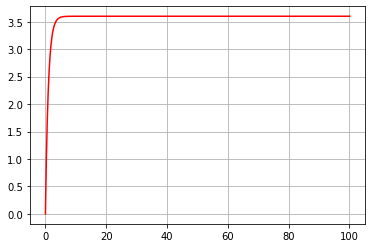

In [25]:
k = 0.5  # control gain
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time difference
L = 2.9  # [m] Wheel base of vehicle
max_steer = np.radians(90.0)  # [rad] max steering angle

show_animation = True

class State(object):
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

    def update(self, acceleration, delta):
        delta = np.clip(delta, -max_steer, max_steer)

        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / L * np.tan(delta) * dt
        self.yaw = normalize_angle(self.yaw)
        self.v += acceleration * dt

def pid_control(target, current):
    return Kp * (target - current)


def stanley_control(state, cx, cy, cyaw, last_target_idx):
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy)

    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    # theta_e corrects the heading error
    theta_e = normalize_angle(cyaw[current_target_idx] - state.yaw)
    # theta_d corrects the cross track error
    theta_d = np.arctan2(k * error_front_axle, state.v)
    # Steering control
    delta = theta_e + theta_d

    return delta, current_target_idx


def normalize_angle(angle):
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle


def calc_target_index(state, cx, cy):
    # Calc front axle position
    fx = state.x + L * np.cos(state.yaw)
    fy = state.y + L * np.sin(state.yaw)

    # Search nearest point index
    dx = [fx - icx for icx in cx]
    dy = [fy - icy for icy in cy]
    d = np.hypot(dx, dy)
    target_idx = np.argmin(d)

    # Project RMS error onto front axle vector
    front_axle_vec = [-np.cos(state.yaw + np.pi / 2),
                      -np.sin(state.yaw + np.pi / 2)]
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vec)

    return target_idx, error_front_axle


def main():
    # target course
    # This is the trajectory for going straight, right, straight
    x = np.round([0.0 , 2.041077998578922e-17 ,4.082155997157844e-17 ,6.123233995736765e-17 ,
        8.164311994315688e-17 ,1.0205389992894609e-16 ,1.224646799147353e-16 ,1.428754599005245e-16 ,
        1.6328623988631375e-16 ,1.8369701987210297e-16 ,1.8775859721074502e-16 ,0.00012841425576148353 ,
        0.0006349817464912176 ,0.0017587748208002533 ,0.003728095620400444 ,0.00676027375188662 ,
        0.011061348270156118 ,0.016825628377957192 ,0.02423513714520316 ,0.03345895108159975 ,
        0.04465245560240567 ,0.05795654233061024 ,0.07349677878109216 ,0.09138258426362887 ,
        0.11170644780979064 ,0.1345432245686376 ,0.15994954643860299 ,0.18796338074272026 ,
        0.21860376757620995 ,0.25187076215824034 ,0.2877456032379384 ,0.32619112250763616 ,
        0.36715240326411197 ,0.41055768945647775 ,0.456319539009541 ,0.5043362081633483 ,
        0.5544932467691334 ,0.6066652782604655 ,0.6607179325822162 ,0.7165098958802558 ,
        0.7738950373597585 ,0.8327245714887782 ,0.8928492126829246 ,0.9541212797296883 ,
        1.0163967084187786 ,1.079536933012142 ,1.1434106001480147 ,1.2078950823294394 ,
        1.2728777620792913 ,1.3382570619201895 ,1.4039431993283984 ,1.4698586494973194 ,
        1.5359383019327113 ,1.602129299425812 ,1.6683905496926332 ,1.7346919008608535 ,
        1.8010129720243195 ,1.8673416293341183 ,1.933672096699593 ,2.0000026883684705 ,
        2.0000026883684705 ,2.333336021701804 ,2.666669355035137 ,3.00000268836847 ,
        3.3333360217018035 ,3.666669355035137 ,4.00000268836847 ,4.333336021701803 ,
        4.666669355035136 ,5.00000268836847 ], 2)
    y = np.round([0.0 ,0.3333333333333333 ,0.6666666666666666 ,1.0 ,1.3333333333333333 ,
        1.6666666666666667 ,2.0 ,2.333333333333333 ,2.6666666666666665 ,
        3.0 ,3.0663305916688777 ,3.132661059034352 ,3.198989716344151 ,
        3.2653107875076173 ,3.3316121386758373 ,3.3978733889426587 ,3.4640643864357594 ,
        3.5301440388711516 ,3.5960594890400723 ,3.6617456264482815 ,3.7271249262891795 ,
        3.792107606039031 ,3.8565920882204563 ,3.9204657553563287 ,3.983605979949692 ,
        4.045881408638783 ,4.107153475685546 ,4.167278116879693 ,4.2261076510087126 ,
        4.283492792488215 ,4.339284755786254 ,4.393337410108005 ,4.445509441599338 ,
        4.495666480205123 ,4.54368314935893 ,4.589444998911993 ,4.632850285104359 ,
        4.673811565860834 ,4.712257085130532 ,4.74813192621023 ,4.7813989207922605 ,
        4.81203930762575 ,4.840053141929868 ,4.865459463799833 ,4.88829624055868 ,
        4.908620104104841 ,4.926505909587378 ,4.94204614603786 ,4.955350232766065 ,
        4.966543737286871 ,4.975767551223267 ,4.983177059990513 ,4.9889413400983145 ,
        4.993242414616584 ,4.996274592748071 ,4.99824391354767 ,4.99936770662198 ,
        4.99987427411271 ,5.00000268836847 ,5.00000268836847 ,5.00000268836847 ,
        5.00000268836847 ,5.00000268836847 ,5.00000268836847 ,5.00000268836847 ,
        5.00000268836847 ,5.00000268836847 ,5.00000268836847 ,5.00000268836847 ,
        5.00000268836847 ], 2)
    cx, cy, cyaw, ck, s = calc_spline_course(x, y, ds=0.1)
    target_speed = 1 #30.0 / 3.6  # [m/s]
    max_simulation_time = 100.0

    # Initial state
    state = State(x=-0.0, y=5.0, yaw=np.radians(20.0), v=0.0)

    last_idx = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_idx, _ = calc_target_index(state, cx, cy)

    while max_simulation_time >= time and last_idx > target_idx:
        ai = pid_control(target_speed, state.v)
        di, target_idx = stanley_control(state, cx, cy, cyaw, target_idx)
        state.update(ai, di)
        time += dt
        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

    # Test
    assert last_idx >= target_idx, "Cannot reach goal"

    if show_animation: 

        plt.subplots(1)
        plt.plot(t, [iv * 3.6 for iv in v], "-r")
        plt.grid(True)
        plt.show()

if __name__ == '__main__':
    main()